シミュレータと整合しない結果
- Tip の出力分布に期待している多峰性が見られない
    - 6mmの時に, 総流出量に差
    - 20mm,30mm と 40mm,50mm の終了時間に差
- Shakeで目標量に達しない場合

修正項目
- 実験セットアップ
    - 少量の damount (<=0.5g) は流出していないと判定
    - 回転角速度を増加
    - shake の降る速度を増加
        - スキルの使い分けが効く状況のはずの6mmでTipと大差がない
    - 内容量の調整
        - 実機実験では完全な詰まりが見られなかった (6mmですら少量ながら安定して流出)
        - 手動実験時は約120g (1.2g/ml * 100ml) で実験, 3mmで完全な詰まりを観測
            - サイズに3mmを追加, 詰まりが起こることを確認
- 実装
    - スキルで共通する処理の関数化, リファクタリング
    - FLOW 判定される damount の閾値
    - ct.robot.MoveToX(blocking=False) 実行後の sleep (0.5 → 0.1)
        - sleep 間のログが失われる
    - ログは100hz + state が変わったタイミングで, 動作始めに記録

検討項目
- 最大角に到達した場合に終了するか
    - 残しておく動機 (なかなか出ないのであればshakeを使うべき)〇
        - 最大角の終了条件はシミュレータに存在, 逆さにしなければならないほど出にくい場合は shake を使ってもらうため
        - 最大角の終了条件は出力分布の多峰性に影響を及ぼす可能性がある
    - 外す動機
        - 仮に詰まりを起こして流出がストップするのであれば, 最大角の終了条件によらず出力分布に多峰性が現れるはず
        - ぽたぽたのダイナミクスをモデル化

# セットアップ

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from copy import deepcopy
import numpy as np

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# colors = ['blue','red','orange','green','purple']

In [2]:
base_logdirs = lambda s,r: glob(f'./robot_pour/h2_{s}_r{r}*')
print(base_logdirs('tip',''))
print(base_logdirs('tip',0.003))

['./robot_pour\\h2_tip_r0.003_d0.092_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.005_d0.09_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.005_d0.09_tm3.14159265359_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.007_d0.088_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.007_d0.088_tm3.14159265359_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.015_d0.08_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2', './robot_pour\\h2_tip_r0.025_d0.07_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2']
['./robot_pour\\h2_tip_r0.003_d0.092_tm2.82743338823_ma100.0_md4.0_mt90.0_dt0.04_sr0.04_sa0.0_ss0.2']


In [3]:
logs_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.003)[0]+'*/*/log.csv')]

In [33]:
def plot(df, vis_amount=True, vis_angle=True):
    vis_keys = ['ROTATE', 'KEEP', 'FLOW', 'MAX TIME', 'MAX AMOUNT', 'MAX THETA', 'SHAKE', 'Exception']
    # vis_keys = ['KEEP']

    if vis_amount:
        fig = go.Figure()
        for i, state in enumerate(vis_keys):
            tmp_df = df[df.status == state]
            if (state in ['KEEP', 'MAX AMOUNT', 'MAX THETA', 'MAX TIME']) and len(tmp_df) >= 10000:
                tmp_df = tmp_df[::1000]
            fig.add_trace(go.Scatter(dict(
                mode = 'markers',
                x = tmp_df.times, y = tmp_df.amounts,
                name = state,
        #         marker = dict(
        #             color = colors[i],
        #         ),
            )))
        fig.update_layout(dict(
            xaxis_title = 'time (s)',
            yaxis_title = 'amount (g)',
        ))
        fig.show()
    
    if vis_angle:
        fig = go.Figure()
        for i, state in enumerate(vis_keys):
            tmp_df = df[df.status == state]
            if (state in ['KEEP', 'MAX AMOUNT', 'MAX THETA', 'MAX TIME']) and len(tmp_df) >= 10000:
                tmp_df = tmp_df[::1000]
            fig.add_trace(go.Scatter(dict(
                mode = 'markers',
                x = tmp_df.times, y = np.rad2deg(tmp_df.rads),
                name = state,
        #         marker = dict(
        #             color = colors[i],
        #         ),
            )))
        fig.update_layout(dict(
            xaxis_title = 'time (s)',
            yaxis_title = 'angle (deg)',
        ))
        fig.show()

# Tip と Shake の比較 (流出量, 時間)

Tip :  [6.0, 6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]
Shake :  [6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]


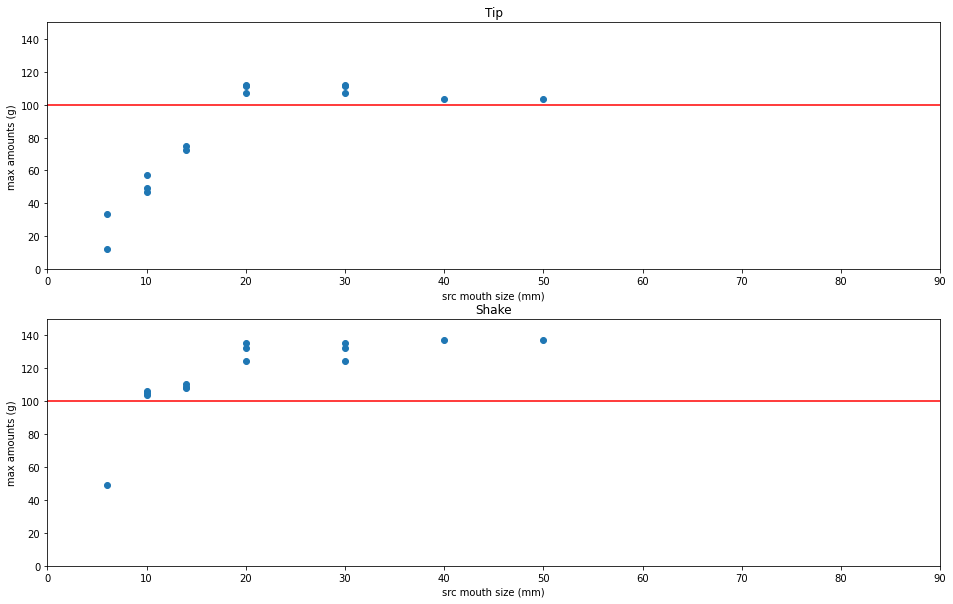

In [5]:
r_list = (np.linspace(0.03,0.08,6)/2).tolist() + (np.linspace(0.02,0.028,5)/2).tolist() + (np.linspace(0.005,0.019,15)/2).tolist()
fig = plt.figure(figsize=(16,10))

x_list = []
max_amount_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',r)[0]+'*/*/log.csv')]
        if r == 0.005:
            log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_amount_list.append(df.amounts.max())
    except:
        pass
print('Tip : ', sorted(np.array(x_list)*2*1000))
plt.subplot(2,1,1)
plt.scatter(x=np.array(x_list)*2*1000, y=max_amount_list)
plt.title('Tip')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max amounts (g)')
plt.xlim(0,90)
plt.ylim(0,150)
plt.hlines(xmin=0,xmax=90,y=100,color='red')

x_list = []
max_amount_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',r)[0]+'*/*/log.csv')]
#         if r == 0.005:
#             log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_amount_list.append(df.amounts.max())
    except:
        pass
print('Shake : ', sorted(np.array(x_list)*2*1000))
plt.subplot(2,1,2)
plt.scatter(x=np.array(x_list)*2*1000, y=max_amount_list)
plt.title('Shake')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max amounts (g)')
plt.xlim(0,90)
plt.ylim(0,150)
plt.hlines(xmin=0,xmax=90,y=100,color='red')

plt.show()

Tip :  [6.0, 6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]
Shake :  [6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]


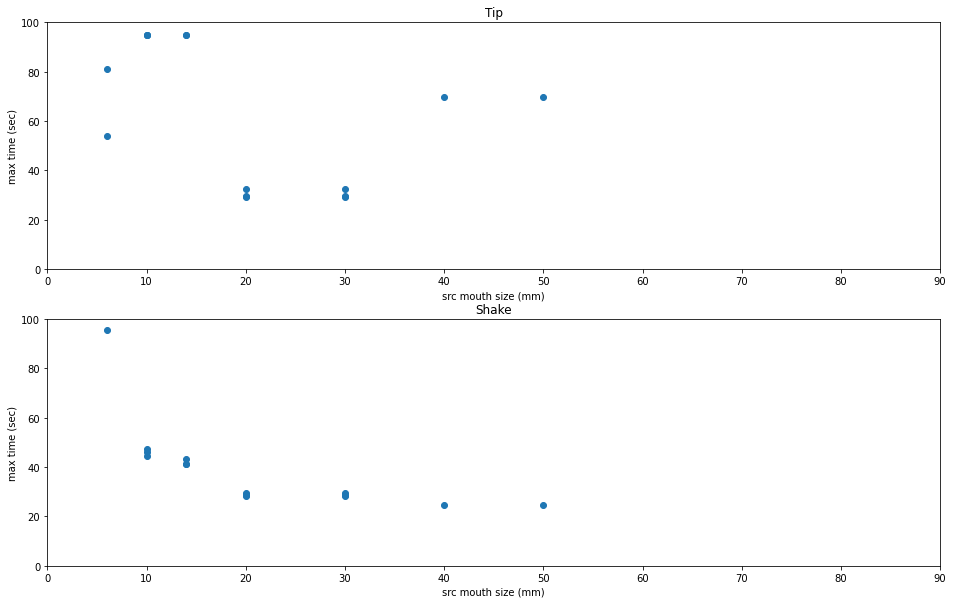

In [6]:
r_list = (np.linspace(0.03,0.08,6)/2).tolist() + (np.linspace(0.02,0.028,5)/2).tolist() + (np.linspace(0.005,0.019,15)/2).tolist()
fig = plt.figure(figsize=(16,10))

x_list = []
max_time_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',r)[0]+'*/*/log.csv')]
        if r == 0.005:
            log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_time_list.append(df.times.max())
    except:
        pass
print('Tip : ', sorted(np.array(x_list)*2*1000))
plt.subplot(2,1,1)
plt.scatter(x=np.array(x_list)*2*1000, y=max_time_list)
plt.title('Tip')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max time (sec)')
plt.xlim(0,90)
plt.ylim(0,100)

x_list = []
max_time_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',r)[0]+'*/*/log.csv')]
#         if r == 0.005:
#             log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_time_list.append(df.times.max())
    except:
        pass
print('Shake : ', sorted(np.array(x_list)*2*1000))
plt.subplot(2,1,2)
plt.scatter(x=np.array(x_list)*2*1000, y=max_time_list)
plt.title('Shake')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max time (sec)')
plt.xlim(0,90)
plt.ylim(0,100)

plt.show()

## Tip の size に対する 流出量, 時間, 角度

Tip :  [6.0, 6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]


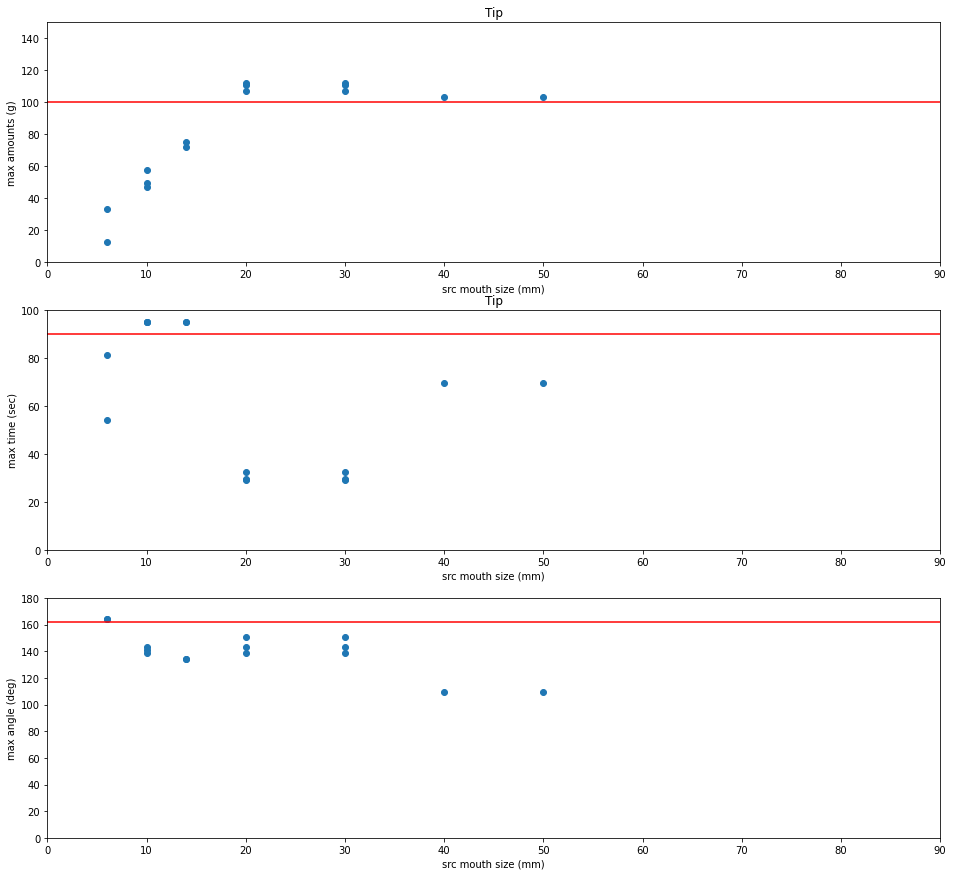

In [7]:
r_list = (np.linspace(0.03,0.08,6)/2).tolist() + (np.linspace(0.02,0.028,5)/2).tolist() + (np.linspace(0.005,0.019,15)/2).tolist()
fig = plt.figure(figsize=(16,15))

x_list = []
max_time_list = []
max_angle_list = []
max_amount_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',r)[0]+'*/*/log.csv')]
        if r == 0.005:
            log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_amount_list.append(df.amounts.max())
            max_time_list.append(df.times.max())
            max_angle_list.append(df.rads.max())
    except:
        pass
    
print('Tip : ', sorted(np.array(x_list)*2*1000))
plt.subplot(3,1,1)
plt.scatter(x=np.array(x_list)*2*1000, y=max_amount_list)
plt.title('Tip')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max amounts (g)')
plt.xlim(0,90)
plt.ylim(0,150)
plt.hlines(xmin=0,xmax=90,y=100,color='red')

plt.subplot(3,1,2)
plt.hlines(xmin=0,xmax=90,y=90,color='red')
plt.scatter(x=np.array(x_list)*2*1000, y=max_time_list)
plt.title('Tip')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max time (sec)')
plt.xlim(0,90)
plt.ylim(0,100)

plt.subplot(3,1,3)
plt.hlines(xmin=0,xmax=90,y=np.rad2deg(0.9*np.pi),color='red')
plt.scatter(x=np.array(x_list)*2*1000, y=np.rad2deg(max_angle_list))
plt.xlabel('src mouth size (mm)')
plt.ylabel('max angle (deg)')
plt.xlim(0,90)
plt.ylim(0,180)

plt.show()

## Shake の size に対する 流出量, 時間

Shake :  [6.0, 10.0, 10.0, 10.0, 14.0, 14.0, 14.0, 20.0, 20.0, 20.0, 30.0, 30.0, 30.0, 40.0, 50.0]


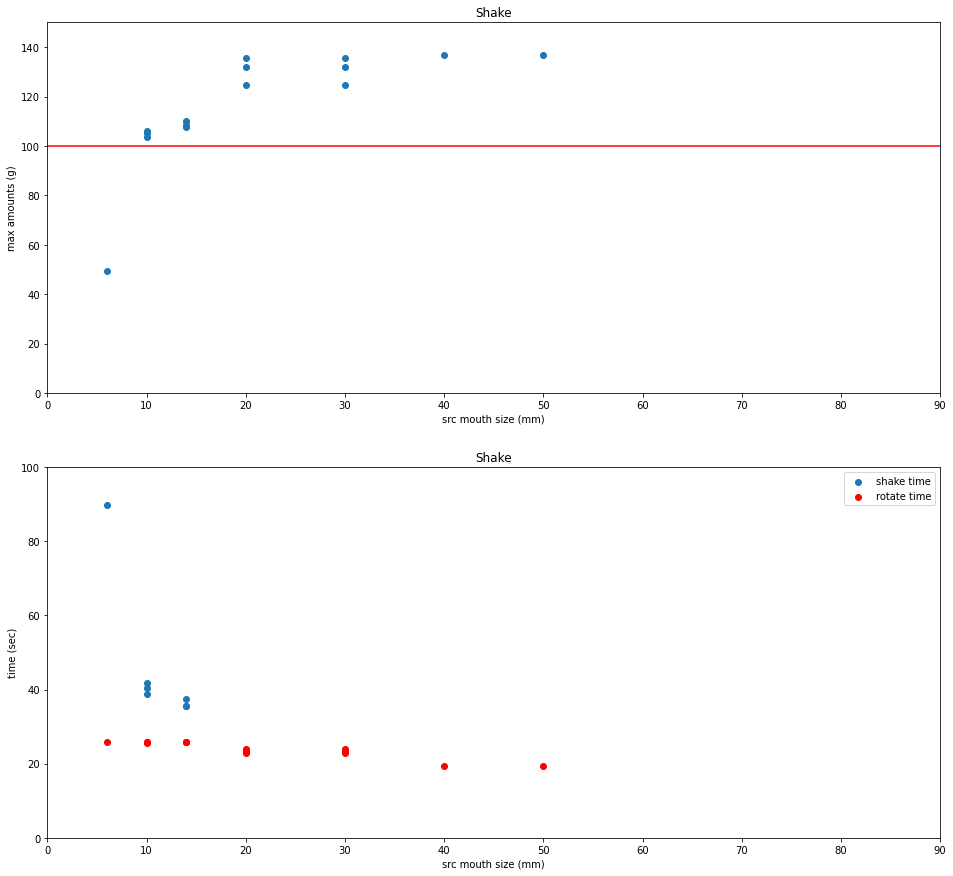

In [21]:
r_list = (np.linspace(0.03,0.08,6)/2).tolist() + (np.linspace(0.02,0.028,5)/2).tolist() + (np.linspace(0.005,0.019,15)/2).tolist()
fig = plt.figure(figsize=(16,15))

x_list = []
max_amount_list = []
shaking_time_list = []
rotate_time_list = []
for r in r_list:
    r = round(r, 4)
#     print(r)
    try:
        log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',r)[0]+'*/*/log.csv')]
#         if r == 0.005:
#             log_dfs = log_dfs[-3:]
        for df in log_dfs:
            x_list.append(r)
            max_amount_list.append(df.amounts.max())
            shaking_time_list.append(df[df.status=='SHAKE'].times.max())
            rotate_time_list.append(df[df.status=='ROTATE'].times.max())
    except:
        pass
    
print('Shake : ', sorted(np.array(x_list)*2*1000))
plt.subplot(2,1,1)
plt.scatter(x=np.array(x_list)*2*1000, y=max_amount_list)
plt.title('Shake')
plt.xlabel('src mouth size (mm)')
plt.ylabel('max amounts (g)')
plt.xlim(0,90)
plt.ylim(0,150)
plt.hlines(xmin=0,xmax=90,y=100,color='red')

plt.subplot(2,1,2)
plt.scatter(x=np.array(x_list)*2*1000, y=shaking_time_list, label='shake time')
plt.scatter(x=np.array(x_list)*2*1000, y=rotate_time_list, color='red', label='rotate time')
plt.title('Shake')
plt.xlabel('src mouth size (mm)')
plt.ylabel('time (sec)')
plt.xlim(0,90)
plt.ylim(0,100)
plt.legend()

plt.show()

# 個別の例

## Tip, 6mm

In [23]:
plot(log_dfs[0], vis_angle=False)
plot(log_dfs[1], vis_angle=False)

In [34]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.003)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_amount=False, vis_angle=True)
plot(log_dfs[1], vis_amount=False, vis_angle=True)

## Shake, 6mm

In [10]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',0.003)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=False)

## Tip, 14mm

In [25]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.007)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=False)
plot(log_dfs[1], vis_angle=False)

## Shake, 14mm

In [26]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',0.007)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=False)
plot(log_dfs[1], vis_angle=False)

## Tip, 30mm

In [31]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.015)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=True)

In [9]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.015)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=False)
plot(log_dfs[1], vis_angle=False)
plot(log_dfs[2], vis_angle=False)

## Tip, 50mm

In [30]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('tip',0.025)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=True)

## Shake, 50mm

In [27]:
log_dfs = [pd.read_csv(log_csv_path) for log_csv_path in  glob(base_logdirs('shake',0.025)[0]+'*/*/log.csv')]

plot(log_dfs[0], vis_angle=False)